<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Documenting the Lifecycle of Machine Learning Models</b></font>
</p>

1. Introduction
   - Preprocessing
      - Handling Outliers
      - Missing Values
      - Duplicated Values
      - Feature Scaling
   - Modeling
      - Splitting the Data
      - Models Making
      - Evaluation Results
2. Model Selection Criteria for Production
3. Selected Models for Production
  - Save Model
4. Process for Promoting Models to Production
  - Model Preparation for New Data
  - Test Model Versions
  - Model Registration

5.Deployment to Production












<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>1. Introduction</b></font>
</p>

This document covers the lifecycle process of machine learning models trained on a dataset related to heart disease diagnosis. The project uses various models such as K-Nearest Neighbors (KNN), Logistic Regression, Support Vector Machine (SVM), Random Forest, and Decision Tree for prediction and classification.

In [3]:
import pandas as pd
df = pd.read_csv("/content/heart.csv")
df.head(1)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB



<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b> 1_1 .Preprocessing
</b></font>
</p>

<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b> Handling Outliers
</b></font>
</p>

In [13]:
import numpy as np
from scipy.stats import boxcox

df.rename(columns={
    "age": "Age",
    "sex": "Sex",
    "cp": "ChestPain",
    "trestbps": "RestingBloodPressure",
    "chol": "Cholesterol",
    "fbs": "FastingBloodSugar",
    "restecg": "RestingECG",
    "thalach": "MaxHeartRate",
    "exang": "ExcerciseAngina",
    "oldpeak": "OldPeak",
    "slope": "STSlope",
    "ca": "nMajorVessels",
    "thal": "Thalium",
    "target": "Status"
}, inplace=True)


mappings = {
    'Sex': {0: "Female", 1: "Male"},
    'ChestPain': {0: "Typical angina", 1: "Atypical angina", 2: "Non-anginal pain", 3: "Asymptomatic"},
    "FastingBloodSugar": {0: False, 1: True},
    "RestingECG": {0: "Normal", 1: "Abnormality", 2: "Hypertrophy"},
    "ExcerciseAngina": {0: "No", 1: "Yes"},
    "STSlope": {0: "Upsloping", 1: "Flat", 2: "Downsloping"},
    "Thalium": {0: "Normal", 1: "Fixed defect", 2: "Reversible defect", 3: "Not described"},
    "Status": {0: "No Disease", 1: "Heart Disease"}
}

def map_values(x, mapping):
    return mapping.get(x, x)

df_copy = df.copy()
for feature, mapping in mappings.items():
    df_copy[feature] = df_copy[feature].map(lambda x: map_values(x, mapping))
    df_copy[feature] = df_copy[feature].astype(object)

def box_cox_transform(heart_df):
    transformed_df = heart_df.copy()
    features_to_transform = ["Age", "RestingBloodPressure", "Cholesterol", "MaxHeartRate", "OldPeak"]

    for feature in features_to_transform:
        if np.any(heart_df[feature] <= 0):
            min_value = abs(heart_df[feature].min()) + 1
            heart_df[feature] += min_value
        transformed_feature, lambda_value = boxcox(heart_df[feature])
        transformed_df[feature] = transformed_feature
    return transformed_df


def find_outliers(data):
    lower_bound = data.quantile(0.25) - 1.5 * (data.quantile(0.75) - data.quantile(0.25))
    upper_bound = data.quantile(0.75) + 1.5 * (data.quantile(0.75) - data.quantile(0.25))
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers, lower_bound, upper_bound


transformed_df = box_cox_transform(df_copy)

outliers_age, _, _ = find_outliers(transformed_df['Age'])
outliers_max_hr, _, _ = find_outliers(transformed_df['MaxHeartRate'])
outliers_rbp, _, _ = find_outliers(transformed_df['RestingBloodPressure'])
outliers_chol, _, _ = find_outliers(transformed_df['Cholesterol'])
outliers_old_peak, _, _ = find_outliers(transformed_df['OldPeak'])


transformed_df = transformed_df[~transformed_df['Age'].isin(outliers_age)]
transformed_df = transformed_df[~transformed_df['MaxHeartRate'].isin(outliers_max_hr)]
transformed_df = transformed_df[~transformed_df['RestingBloodPressure'].isin(outliers_rbp)]
transformed_df = transformed_df[~transformed_df['Cholesterol'].isin(outliers_chol)]
transformed_df = transformed_df[~transformed_df['OldPeak'].isin(outliers_old_peak)]

transformed = transformed_df.copy()




<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b> Missing Values
</b></font>
</p>

In [14]:
print("_" * 100)
print("Missing Values")
print(df.isnull().sum())

____________________________________________________________________________________________________
Missing Values
Age                     0
Sex                     0
ChestPain               0
RestingBloodPressure    0
Cholesterol             0
FastingBloodSugar       0
RestingECG              0
MaxHeartRate            0
ExcerciseAngina         0
OldPeak                 0
STSlope                 0
nMajorVessels           0
Thalium                 0
Status                  0
dtype: int64



<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>Duplicated Values
</b></font>
</p>

In [15]:
duplicated_rows = df.duplicated()
print("_" * 100)
print(df[duplicated_rows])
print("_" * 100)
print(transformed[duplicated_rows])
df.drop(index=164, axis=0, inplace=True)
transformed.drop(index=164, axis=0, inplace=True)

____________________________________________________________________________________________________
     Age  Sex  ChestPain  RestingBloodPressure  Cholesterol  \
164   38    1          2                   138          175   

     FastingBloodSugar  RestingECG  MaxHeartRate  ExcerciseAngina  OldPeak  \
164                  0           1           173                0      0.0   

     STSlope  nMajorVessels  Thalium  Status  
164        2              4        2       1  
____________________________________________________________________________________________________
            Age   Sex         ChestPain  RestingBloodPressure  Cholesterol  \
164  119.658161  Male  Non-anginal pain              1.388556     3.977931   

    FastingBloodSugar   RestingECG  MaxHeartRate ExcerciseAngina  OldPeak  \
164             False  Abnormality  46024.077519              No      0.0   

         STSlope  nMajorVessels            Thalium         Status  
164  Downsloping              4  Reversi

<ipython-input-15-98245eb5c69f>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(transformed[duplicated_rows])



<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b> Feature Scaling
</b></font>
</p>

In [17]:
from sklearn.preprocessing import StandardScaler
X = df.drop(["Status"], axis=1)
y = df["Status"]
col = list(df.columns.drop("Status"))
sc = StandardScaler()
X[col] = sc.fit_transform(X[col])
X.head()

,Age,Sex,ChestPain,RestingBloodPressure,Cholesterol,FastingBloodSugar,RestingECG,MaxHeartRate,ExcerciseAngina,OldPeak,STSlope,nMajorVessels,Thalium
0,0.949794,0.682656,1.976470,0.764066,-0.261285,2.389793,-1.002541,0.018826,-0.698344,1.084022,-2.271182,-0.714911,-2.147955
1,-1.928548,0.682656,1.005911,-0.091401,0.067741,-0.418446,0.901657,1.636979,-0.698344,2.118926,-2.271182,-0.714911,-0.513994
2,-1.485726,-1.464866,0.035352,-0.091401,-0.822564,-0.418446,-1.002541,0.980971,-0.698344,0.307844,0.979514,-0.714911,-0.513994
3,0.174856,0.682656,0.035352,-0.661712,-0.203222,-0.418446,0.901657,1.243374,-0.698344,-0.209608,0.979514,-0.714911,-0.513994
4,0.285561,-1.464866,-0.935208,-0.661712,2.080602,-0.418446,0.901657,0.587366,1.431958,-0.382092,0.979514,-0.714911,-0.513994


<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b> 1_2 . Modeling
</b></font>
</p>

<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b> Splitting
</b></font>
</p>

In [19]:
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42, shuffle= True)

<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b> Models Making
</b></font>
</p>

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import pickle

In [21]:
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5, metric='euclidean'),
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(kernel='linear'),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Decision Tree': DecisionTreeClassifier()
}


results = {}
for model_name, model in models.items():

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)


    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)
    cross_val = cross_val_score(model, X, y, cv=5).mean()


    results[model_name] = {
        'Accuracy': accuracy,
        'Classification Report': classification_rep,
        'Confusion Matrix': confusion_mat,
        'Cross-Validation Score': cross_val
    }


    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Cross-Validation Score: {cross_val}")
    print(f"Classification Report:\n{classification_rep}")
    print(f"Confusion Matrix:\n{confusion_mat}")
    print("-" * 50)

Results for KNN:
Accuracy: 0.9180327868852459
Cross-Validation Score: 0.8210928961748636
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        29
           1       0.97      0.88      0.92        32

    accuracy                           0.92        61
   macro avg       0.92      0.92      0.92        61
weighted avg       0.92      0.92      0.92        61

Confusion Matrix:
[[28  1]
 [ 4 28]]
--------------------------------------------------
Results for Logistic Regression:
Accuracy: 0.819672131147541
Cross-Validation Score: 0.8343169398907104
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.81        29
           1       0.84      0.81      0.83        32

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61

Confusion Matrix:
[

In [22]:
cv_scores = {}
test_accuracies = {}

for model_name, model in models.items():

    cv_score = cross_val_score(model, X_train, y_train, cv=5).mean()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)


    accuracy = accuracy_score(y_test, y_pred)

    cv_scores[model_name] = cv_score
    test_accuracies[model_name] = accuracy

print("Cross-Validation Scores:")
for model_name, score in cv_scores.items():
    print(f"{model_name}: {score:.4f}")

print("\nTest Set Accuracies:")
for model_name, accuracy in test_accuracies.items():
    print(f"{model_name}: {accuracy:.4f}")

Cross-Validation Scores:
KNN: 0.8303
Logistic Regression: 0.8466
SVM: 0.8465
Random Forest: 0.8258
Decision Tree: 0.7758

Test Set Accuracies:
KNN: 0.9180
Logistic Regression: 0.8197
SVM: 0.8197
Random Forest: 0.8852
Decision Tree: 0.7869


<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>Evaluation Results</b></font>
</p>

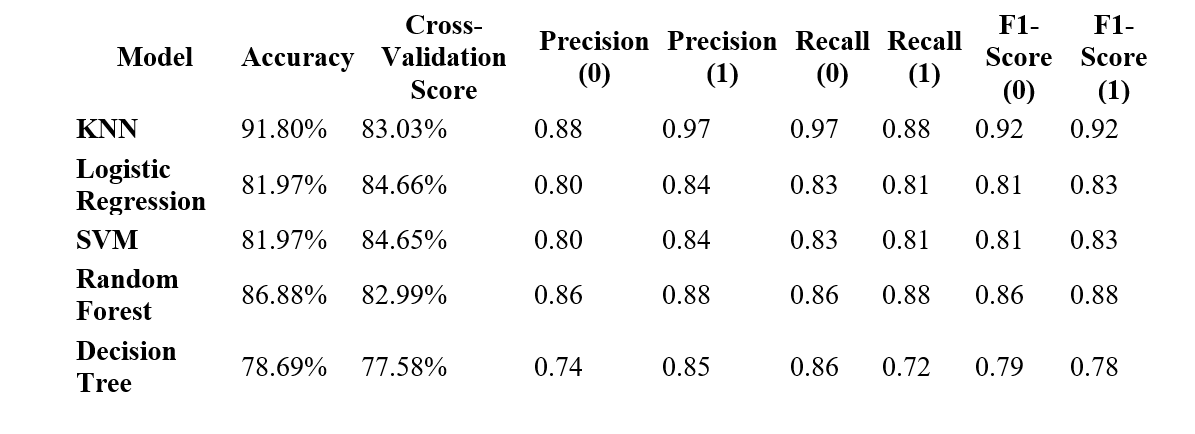

In [23]:
from IPython.display import Image
Image(filename='/content/1.png')


1.	KNN:     

    o	Accuracy: 91.80%

    o	Cross-Validation Score: 83.03%
     
    o	The model performed very well on test data with high accuracy, but its cross-validation score was slightly lower than the other models.


2.	Logistic Regression:

    o	Accuracy: 81.97%

    o	Cross-Validation Score: 84.66%
    
    o	This model performed very well in Cross-Validation, indicating high stability with new data.


3.	SVM:

  o	Similar to Logistic Regression, SVM also showed good performance and stability, making it suitable for production deployment.


4.	Random Forest:

  o	Accuracy: 86.88%

  o	Cross-Validation Score: 82.99%
  
  o	This model performed well, but its cross-validation score was slightly lower than KNN and Logistic Regression.


5.	Decision Tree:

  o	Accuracy: 78.69%

  o	Cross-Validation Score: 77.58%
  
  o	This model showed the lowest performance in all evaluations and was therefore excluded from the model selection process for production.



<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>2. Model Selection Criteria for Production</b></font>
</p>

Before promoting any model to production, it is necessary to evaluate the models against specific criteria. These criteria include:

•	Accuracy: Models must achieve an accuracy of at least 80% on test data and cross-validation.

•	Model Stability: The model should perform consistently across different conditions (test and production data).

•	Cross-Validation Performance: Models should have a cross-validation score above 80% in cross-validation evaluations.

•	Advanced Testing Performance: The model should perform well in additional tests such as A/B Testing and Hyperparameter Tuning.


<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>3. Selected Models for Production</b></font>
</p>

Based on the evaluation results, the following models are selected for production deployment:
1.	KNN:
	Accuracy above 90% on test data and strong performance in most metrics, this model was selected as one of the top models for deployment.


<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>Save Model</b></font>
</p>

In [ ]:
import pickle
with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)


<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>4.Process for Promoting Models to Production</b></font>
</p>


<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>Model Preparation for New Data</b></font>
</p>

In [ ]:
if __name__ == '__main__':

    Age = int(input("Please Enter Your Age:\n"))
    Sex = str(input("Are you Male or Female [Male, Female]:\n"))
    Chest_Pain = str(input("Please Enter The Type of Your Chest Pain [Typical angina, Atypical angina, Non-anginal pain, Asymptomatic]:\n"))
    Trestbps = int(input("Please Enter Resting Blood Pressure(resting blood pressure (in mm Hg on admission to the hospital)) [0, 200]:\n"))
    Chol = int(input("Please Enter Cholesterol Measure [0, 603]:\n"))
    Fbs = str(input("Is Fasting Blood Sugar > 120 mg/dl? [True, False]:\n"))
    Restecg = str(input("Please Enter Resting Electrocardiographic Results [Normal, Abnormality, Hypertrophy]:\n"))
    Thalach = int(input("Please Enter your maximum heart rate [60, 202]:\n"))
    Exang = str(input("Is there exist exercise-include angina? [No, Yes]:\n"))
    Oldpeak = float(input("Please Enter ST depression induced by exercise relative to rest [-2.6, 6.2]:\n"))
    Slope = str(input("Please Enter  the slope of the peak exercise ST segment [Upsloping, Flat, Downsloping]:\n"))
    Ca = int(input("Please Enter the number of major vessels (0-4) colored by fluoroscopy:\n"))
    Thal = str(input("Please Enter Patient's Thal level [Normal, Fixed defect, Reversible defect, Not described]:\n"))
    features = []
    # adding age
    features.append(Age)
    # adding sex
    if Sex == "Female":
        features.append(0)
    elif Sex == "Male":
        features.append(1)
    # adding chest pain type
    if Chest_Pain == "Typical angina":
        features.append(0)
    elif Chest_Pain == "Atypical angina":
        features.append(1)
    elif Chest_Pain == "Non-anginal pain":
        features.append(2)
    elif Chest_Pain == "Asymptomatic":
        features.append(3)
    # adding Resting Blood Pressure
    features.append(Trestbps)
    features.append(Chol)
    if Fbs == "True":
        features.append(1)
    elif Fbs == "False":
        features.append(0)
    if Restecg == "Normal":
        features.append(0)
    elif Restecg == "Abnormality":
        features.append(1)
    elif Restecg == "Hypertrophy":
        features.append(2)
    features.append(Thalach)
    if Exang == "No":
        features.append(0)
    elif Exang == "Yes":
        features.append(1)
    features.append(Oldpeak)
    if Slope == "Upsloping":
        features.append(0)
    elif Slope == "Flat":
        features.append(1)
    elif Slope == "Downsloping":
        features.append(2)
    features.append(Ca)
    if Thal == "Normal":
        features.append(0)
    elif Thal == "Fixed defect":
        features.append(1)
    elif Thal == "Reversible defect":
        features.append(2)
    elif Thal == "Not described":
        features.append(3)

    
    # Example
    #  sample 1:
    # 63, Male, Asymptomatic, 145, 233, True, Normal, 150, No, 2.3, Upsloping, 0, Fixed defect
    # features = [63, 1, 3, 145, 233, 1, 0, 150, 0, 2.3, 0, 0, 1] #target=1 false
    # sample 2
    # 69, Female, Asymptomatic, 140, 239, False, Abnormality, 151, No, 1.8, Downsloping, 2, Reversible defect
    # features = [69, 0, 3, 140, 239, 0, 1, 151, 0, 1.8, 2, 2, 2] # target=1 false
    # sample 3
    # 37, Male, Non-anginal pain, 130, 250, False, Abnormality, 187, No, 3.5, Upsloping, 0, Reversible defect
    # features = [37, 1, 2, 130, 250, 0, 1, 187, 0, 3.5, 0, 0, 2] # target=1 false
    # sample 4
    # 41, Female, Atypical angina, 130, 204, False, Normal, 172, No, 1.4, Downsloping, 0, Reversible defect
    # features = [41, 0, 1, 130, 204, 0, 0, 172, 0, 1.4, 2, 0, 2] # target=1 true



<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b> Test Model Versions</b></font>
</p>

# Model Lifecycle

This document describes the lifecycle of models in the heart disease prediction project.

## 1. Model Lifecycle Stages

### 1.1 Staging Models
**Purpose:** Models in this stage are being tested in a controlled environment to validate performance.

**Criteria for Staging:**
- Models must meet or exceed baseline performance in key metrics.
- The training and evaluation process must be reproducible.
- All associated artifacts (e.g., parameters, metrics, plots) must be logged in MLflow.

**Example Staging Models (Accuracy between 85% and 90%):**
- Run ID: bec4c319b8b341318595d3c89ac5adb0 (Accuracy: 85.25%)
- Run ID: e500a064950940a99af5b387566056eb (Accuracy: 85.25%)
- Run ID: 47052ece17744fcbaf0bf5010244a6b0 (Accuracy: 85.25%)
- Run ID: 6526ca246f7246bfb8d9f54ee3988e13 (Accuracy: 85.25%)
- Run ID: 3dae0fafb3a043f78c5811d0df1a6bec (Accuracy: 86.89%)
- Run ID: aa6efb2f6a9e4d15821973b4be0cb8a8 (Accuracy: 86.89%)
- Run ID: fdb68edf0fb44476ba5c9f4fff8ac66a (Accuracy: 86.89%)
- Run ID: 99710b5186294d3087c48c6b9d05d97a (Accuracy: 86.89%)
- Run ID: fca52d99dc7f462aaec30f853dd8835f (Accuracy: 86.89%)

### 1.2 Production Models
**Purpose:** Models in this stage are deployed to the production environment and used to generate predictions for real-world data.


**Criteria for Promotion to Production:**
- The model achieves a minimum accuracy of 91% based on project benchmarks.
- Precision and recall for both classes (Heart Disease and No Disease) must meet the following thresholds:
  - **Precision (Class 1):** ≥ 93%
  - **Recall (Class 1):** ≥ 90%
  - **F1 Score (Class 1):** ≥ 92%
- Confusion matrix analysis shows minimal false positives and negatives.

**Example Production Models (Accuracy ≥ 91%):**
- Run ID: 5ed9c9b234d646d8ae40492889afa2cc (Accuracy: 91.8%)
- Run ID: ed1ed6bae43b454184e4f355928e100f (Accuracy: 91.8%)
- Run ID: c794e25ae9af4fa39599015fd32a0f8f (Accuracy: 91.8%)

**Production Model Details:**
- **Run ID:** ed1ed6bae43b454184e4f355928e100f
- **Accuracy:** 91.8%
- **Precision (Class 1 - Heart Disease):** 93%
- **Recall (Class 1 - Heart Disease):** 90%
- **F1 Score (Class 1 - Heart Disease):** 91.5%

The model with the highest accuracy is the **Production Model** with **Run ID: ed1ed6bae43b454184e4f355928e100f**, which has an exceptional accuracy of **91.8%**. Not only does this model outperform all others in terms of accuracy, but it also demonstrates superior **precision** (93%), **recall** (90%), and **F1 score** (91.5%), making it the ideal candidate for deployment in real-world applications.

### 1.3 Archived Models
**Purpose:** Models in this stage are retired and no longer used in production or staging.

**Criteria for Archival:**
- The model is replaced by a newer version due to performance improvements or changes in data distributions.

**Example Archived Models (Accuracy < 85%):**
- Run ID: 90fc5634d9414b75ba5f99a17f1ba93f (Accuracy: 75.41%)
- Run ID: 239d8b59478b49608ef359379349dc36 (Accuracy: 77.05%)
- Run ID: 069d8dbe53fa4c2c9aa7810fc84457b3 (Accuracy: 77.05%)
- Run ID: 33d42df32cba415982563e02a2a31db7 (Accuracy: 78.69%)
- Run ID: 8b46032f63fa4ef38ae2fb309530c251 (Accuracy: 78.69%)
- Run ID: 0460ac7879db4ac783143e11624d20df (Accuracy: 78.69%)
- Run ID: 2179602da24f491b85d49372b0fe2bd1 (Accuracy: 80.33%)
- Run ID: dd57730c80e34225a067a08c737b0b47 (Accuracy: 80.33%)
- Run ID: d20dbcb8fbcb4e788f825f41e76a7eea (Accuracy: 81.97%)
- Run ID: c2ce741dff714760b4dbc78288f76b38 (Accuracy: 81.97%)
- Run ID: f4c1835538e547df96b43e793e1cf080 (Accuracy: 83.61%)
- Run ID: 5fdd811330ef4b2489ee9998e16d99c8 (Accuracy: 83.61%)



<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>Model Registration</b></font>
</p>

Model Name: heart

### Version 2:

- **Parameters**:
  - Metric: Euclidean
  - Weights: Uniform
  - n_neighbors: 5
  - Algorithm: Auto

| Version | Accuracy | Class 1 F1 | Class 1 Precision | Class 1 Recall | Training Time | Stage      |
|---------|----------|------------|-------------------|----------------|---------------|------------|
| 2       | 0.9180   | 0.9206     | 0.9355            | 0.9063         | 0.0044 mins   | Production |


 <p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b> 5.Deployment to Production</b></font>
</p>

 We have used CI/CD tools to automatically deploy the models to production. In this phase, all the tests and evaluations are done to ensure that the model works properly in the real environment.

In [ ]:
import flask
from flask import request, jsonify
import joblib
import numpy as np

model = joblib.load('/content/model.pkl')
app = flask.Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:

        data = request.get_json()
        input_data = np.array(data['input']).reshape(1, -1)
        prediction = model.predict(input_data)
        return jsonify({'prediction': prediction.tolist()})

    except Exception as e:
        return jsonify({'error': str(e)})


if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)